In [468]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [469]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
# from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA
from implicitdl import *

In [470]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:0") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
torch.set_default_device(device)
generator = torch.Generator(device=device)

GPU is available


In [471]:
import numpy as np
import matplotlib.pyplot as plt

generate_data = 0
level = 2

input_dim_gt = level*3
hidden_dim_gt = level*5
output_dim_gt = level*2

np.random.seed(2)
torch.manual_seed(2)

den = 5
Agt = nn.Parameter(torch.randn(hidden_dim_gt, hidden_dim_gt)/den)
Bgt = nn.Parameter(torch.randn(hidden_dim_gt, input_dim_gt))
Cgt = nn.Parameter(torch.randn(output_dim_gt, hidden_dim_gt))
Dgt = nn.Parameter(torch.randn(output_dim_gt, input_dim_gt))
gt_model = ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf).eval()
# initialize the model with the random matrices
gt_model.A = Agt
gt_model.B = Bgt
gt_model.C = Cgt
gt_model.D = Dgt

if generate_data:
    # generate data for training and validation using gt_mode
    n_samples = level*20000
    n_samples_val = 200
    x_values = torch.randn(n_samples, input_dim_gt)*10
    y_values = gt_model(x_values)
    x_values_val = torch.randn(n_samples_val, input_dim_gt)*10
    y_values_val = gt_model(x_values_val)
    # save the data to npz file
    np.savez(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz', x_values=x_values.detach().cpu(), y_values=y_values.detach().cpu(), x_values_val=x_values_val.detach().cpu(), y_values_val=y_values_val.detach().cpu())
    # print(x_values[:5], y_values[:5])

# load from the npz file
data = np.load(f'./kaggle/input/synthetic_fp_data_h{hidden_dim_gt}.npz')
x_values = torch.tensor(data['x_values']).to(device)
y_values = torch.tensor(data['y_values']).to(device)
# print(x_values[:5], y_values[:5])
x_values_val = torch.tensor(data['x_values_val']).to(device)
y_values_val = torch.tensor(data['y_values_val']).to(device)
# into data_loader
training_set = TensorDataset(x_values, y_values)
validation_set = TensorDataset(x_values_val, y_values_val)

# Model

In [472]:
from typing import Optional

   
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)

# Define and train Model

In [473]:
def train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn):
    running_loss = 0.
    last_loss = 0.
    for t, data in enumerate(training_loader):
        x_train, y_train = data
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_fn(y_train_pred, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (t % 10 == 9):
            last_loss = running_loss / 10 # loss per batch
            running_loss = 0.
    return last_loss

def plot_hist(y_axis, xlabel, ylabel, title, x_axis=None, log=False):
    plt.figure()
    if (x_axis is None):
        x_axis = range(len(y_axis))
    if log:
        plt.semilogy(x_axis, y_axis)
    else:
        plt.plot(x_axis, y_axis)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


def evaluate_model(model, validation_loader):
    # Disable gradient computation and reduce memory consumption.
    running_vloss = 0.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels).item()
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    return avg_vloss

In [474]:
make_imp = lambda: ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf, no_D=False, bias=False)
# 1-6, 2-11, 3-16, 4-22, 5-27, 6-33
if level == 1:
    mlp_hidden_dim = 6
elif level == 2:
    mlp_hidden_dim = 11
elif level == 3:
    mlp_hidden_dim = 16
elif level == 4:
    mlp_hidden_dim = 22
elif level == 5:
    mlp_hidden_dim = 27
elif level == 6:
    mlp_hidden_dim = 33
make_mlp = lambda: MLP(input_dim_gt, mlp_hidden_dim, output_dim_gt, act=nn.ReLU)


In [487]:
batch_size = 512
EPOCHS = 90
RUNS = 1

torch.manual_seed(10)
# format data for training to dataloader
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, generator=generator)
loss_fn = torch.nn.MSELoss()
generator = torch.Generator(device=device)

best_vloss = 1_000_000.
up_count = 0
for run_idx in range(RUNS):
    model, lr = make_mlp().to(device), 0.01; #torch.nn.init.normal_(fuse_parameters(model))
    # model, lr = make_imp().to(device), 0.07; torch.nn.init.normal_(fuse_parameters(model), mean=0, std=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    # print(model)
    if run_idx == 0:
        print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')
    
    avg_vloss_all = []
    avg_loss_all = []
    for epoch in range(EPOCHS):
        model.train(True)    
        avg_loss = train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn)
        avg_loss_all.append(avg_loss)
        scheduler.step()

        model.eval()
        avg_vloss = evaluate_model(model, validation_loader)
        avg_vloss_all.append(avg_vloss)
        print(f'Epoch {epoch} loss: {avg_loss}, val loss: {avg_vloss}')

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_model = model
            up_count = 0
        else:
            up_count += 1
        
        if up_count > 15:
            break
    print(f'Run {run_idx} best val loss: {best_vloss}')
# print(f'r2 (higher better):    {np.mean(r2s):.2f} +- {np.std(r2s):.2f}')
# print(f'MAPE (smaller better): {np.mean(mapes):.2f} +- {np.std(mapes):.2f}')
# ############# can calibrate size of RNN to compartible with imp_rnn
# best_r2_index = np.argmax(r2s)
# best_mape_index = np.argmin(mapes)

# print(f'Best r2 (higher better):    {r2s[best_r2_index]:.2f} at iteration {best_r2_index}')
# print(f'Best MAPE (smaller better): {mapes[best_mape_index]:.2f} at iteration {best_mape_index}')

model size: 231 parameters
Epoch 0 loss: 475.5163238525391, val loss: 308.67864990234375
Epoch 1 loss: 145.06073455810548, val loss: 119.35240173339844
Epoch 2 loss: 93.34059219360351, val loss: 76.08799743652344
Epoch 3 loss: 70.12851486206054, val loss: 52.74307632446289
Epoch 4 loss: 51.416116333007814, val loss: 38.92490005493164
Epoch 5 loss: 43.350965118408205, val loss: 34.60980987548828
Epoch 6 loss: 38.066807174682616, val loss: 32.47483825683594
Epoch 7 loss: 34.62116928100586, val loss: 30.465900421142578
Epoch 8 loss: 32.89942951202393, val loss: 28.68708038330078
Epoch 9 loss: 30.827177810668946, val loss: 27.234996795654297
Epoch 10 loss: 29.95922145843506, val loss: 26.321218490600586
Epoch 11 loss: 28.00981731414795, val loss: 24.30569839477539
Epoch 12 loss: 26.415923500061034, val loss: 23.079071044921875
Epoch 13 loss: 25.836627388000487, val loss: 23.17854881286621
Epoch 14 loss: 24.90181770324707, val loss: 22.556400299072266
Epoch 15 loss: 24.857769203186034, val 

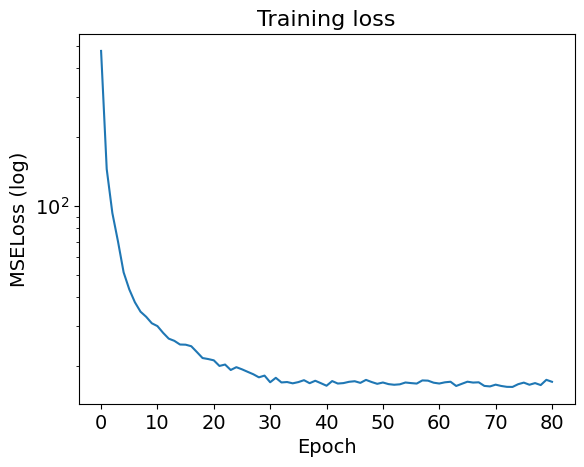

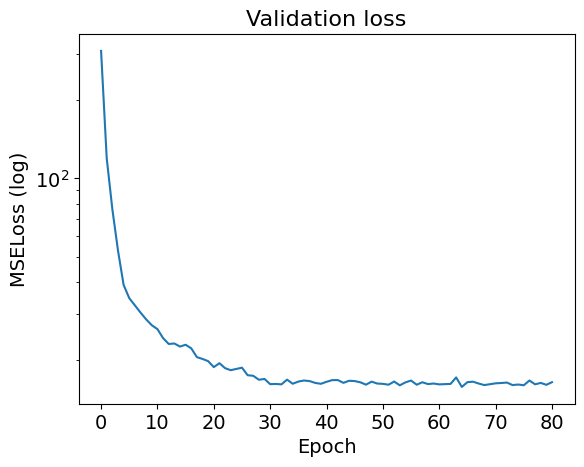

In [488]:
plot_hist(avg_loss_all, 'Epoch', 'MSELoss (log)', 'Training loss', log=True)
plot_hist(avg_vloss_all, 'Epoch', 'MSELoss (log)', 'Validation loss', log=True)

In [489]:
if isinstance(model, ImplicitModel):
    # compare model.A with gt_model.A
    print("A", best_model.A.cpu().detach().numpy())
    print("Agt",gt_model.A.cpu().detach().numpy())
    print("D",best_model.D.cpu().detach().numpy())
    print("Dgt",gt_model.D.cpu().detach().numpy())

    print((best_model.A - gt_model.A).norm().item())
    print((best_model.B - gt_model.B).norm().item())
    print((best_model.C - gt_model.C).norm().item())
    print((best_model.D - gt_model.D).norm().item())


In [490]:
0.0401

0.0401

In [491]:
x_test = torch.randn(1, input_dim_gt)*10000
# x_test = x_values[np.random.randint(0, n_samples)].unsqueeze(0)
y_test = gt_model(x_test)
y_test_pred = best_model(x_test)
print(f'x_test: {x_test.detach().cpu().numpy()}')
print(f'y_test: {y_test.detach().cpu().numpy()}')
print(f'y_test_pred: {y_test_pred.detach().cpu().numpy()}')

running_mape = 0.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = best_model(vinputs)
        mape = ((voutputs - vlabels).norm(dim=1) / vlabels.norm(dim=1)).mean()
        running_mape += mape
avg_mape = running_mape / (i + 1)
print(f'level: {level}, avg mape: {avg_mape}')
print(gt_model.A[-1,0])

x_test: [[-6277.017  -3793.7852 -7104.094   4498.637   2782.4932 15713.917 ]]
y_test: [[ -9125.669  32323.19  -28957.277 -24032.562]]
y_test_pred: [[ -6466.2773  31335.379  -32175.426  -24418.883 ]]
level: 2, avg mape: 0.09452617168426514
tensor(0.2304, device='cuda:0', grad_fn=<SelectBackward0>)


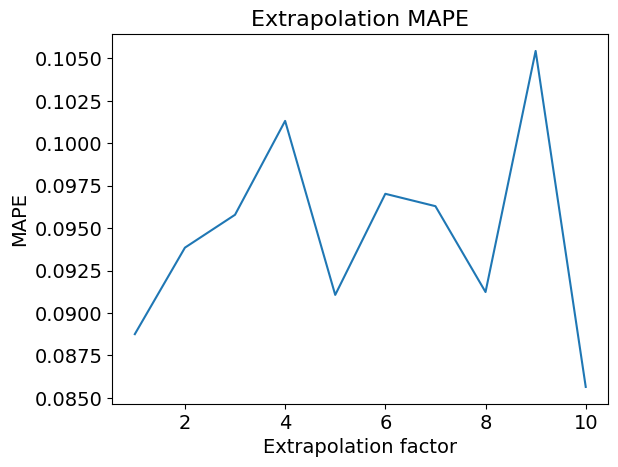

In [492]:
extrap_level = 1
extrap_max = 10
mapes = []
n_samples_val = 200
with torch.no_grad():
    for ood_level in range(extrap_max):
        x_ood = torch.randn(n_samples_val, input_dim_gt)*10**extrap_level
        y_ood = gt_model(x_ood)
        y_ood_pred = best_model(x_ood)
        mape = ((y_ood - y_ood_pred).norm(dim=1) / y_ood_pred.norm(dim=1)).mean()
        mapes.append(mape.cpu())

# figure for mapes
plot_hist(mapes, 'Extrapolation factor', 'MAPE', 'Extrapolation MAPE', x_axis=range(1,extrap_max+1))
